In [84]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

%run '../functions.py'
%run '../classes.py'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/adammajczyk/nltk_data..

In [86]:
save_path = 'grid_search_results_new.json'
grids_path = '../grid_search_grids.json'

In [87]:
model_w2v_settings = return_best_model()

In [88]:
model_w2v_settings['model_path'] = '../all_datasets/' + model_w2v_settings['model_path']

model_w2v = Word2VecModel(model_w2v_settings)

In [89]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

,title,is_clickbait,text,dataset,sample
0,"[seventeen, time, game, throne, matched, perfe...",1,NaN,clickbait-dataset,train
1,"[facing, texas, tar, heel, territory, duke, fi...",0,NaN,clickbait-dataset,train
4,"[wikinews, interview, kevin, baugh, president,...",0,NaN,clickbait-dataset,train
6,"[identify, justin, bieber, music, video, youtu...",1,NaN,clickbait-dataset,train
9,"[uganda, introduces, antihomosexual, legislation]",0,NaN,clickbait-dataset,train


In [90]:
df['sample'].value_counts()


sample
train    28836
test      1607
val2       781
val1       776
Name: count, dtype: int64

In [91]:
# split data into train and test stratified by y
from sklearn.preprocessing import StandardScaler
import os
import pickle

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]
df = df.reset_index(drop=True)
df.head()

,title,is_clickbait,text,dataset,sample,title_vector
0,"[seventeen, time, game, throne, matched, perfe...",1,NaN,clickbait-dataset,train,"[-0.63768053, -0.16730867, 1.2560811, 0.333890..."
1,"[facing, texas, tar, heel, territory, duke, fi...",0,NaN,clickbait-dataset,train,"[0.3366267, 0.00305996, -0.046237264, -0.15608..."
2,"[wikinews, interview, kevin, baugh, president,...",0,NaN,clickbait-dataset,train,"[0.44883993, -0.6124204, 0.11272216, 0.3416544..."
3,"[identify, justin, bieber, music, video, youtu...",1,NaN,clickbait-dataset,train,"[-0.33811563, -0.3635295, 0.47486135, 0.501028..."
4,"[uganda, introduces, antihomosexual, legislation]",0,NaN,clickbait-dataset,train,"[0.61557364, -0.2940396, 0.21883398, 0.4751384..."


In [92]:
df['title_vector'][0]

array([-0.63768053, -0.16730867,  1.2560811 ,  0.3338902 , -0.56454986,
        0.44497627,  0.784385  ,  0.3551108 , -0.8828402 ,  0.59592795,
        0.1280393 , -0.64912486,  0.81945324, -0.3996215 ,  0.32769346,
        1.2330511 ,  0.67513835, -0.43883395,  0.24185432, -0.9126102 ],
      dtype=float32)

In [93]:
variables_to_drop = get_dimensions_to_drop()
variables_to_drop

[16, 14, 2, 11, 10, 6, 15, 18, 12, 8, 13, 3, 1, 4, 17, 19, 9, 0]

In [94]:
df['title_vector'] = [drop_dimensions_from_vector(vector, variables_to_drop) for vector in df['title_vector']]

In [95]:
df['title_vector'][0]

array([0.44497627, 0.3551108 ], dtype=float32)

In [96]:
X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])

y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:
import json

with open(grids_path, 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

{'decision_tree_grid': {'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'max_features': ['sqrt', 'log2', None]},
 'catboost_grid': {'iterations': [100, 250, 500],
  'learning_rate': [None, 0.001, 0.01, 0.1, 0.2, 0.3],
  'depth': [3, 4, 5, 6, 7, 8],
  'l2_leaf_reg': [1, 3, 5, 7, 9]},
 'lightgbm_grid': {'n_estimators': [50, 100, 250, 500],
  'learning_rate': [None, 0.01, 0.1, 0.2, 0.3],
  'max_depth': [-1, 3, 4, 5, 6, 7, 8],
  'num_leaves': [15, 31, 62, 93, 124, 155, 187, 217]},
 'xgboost_grid': {'n_estimators': [10, 25, 50, 100, 250],
  'learning_rate': [None, 0.001, 0.01, 0.1, 0.2, 0.3],
  'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'gamma': [0, 0.01, 0.1, 0.5, 1, 5]},
 'random_forest_grid': {'n_estimators': [50, 100, 250, 500],
  'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'max_features': ['sqrt', 'log2', None]}}

In [98]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

# remove _grid from model names
models_to_CV = [model_name.replace('_grid', '') for model_name in models_to_CV]
models_to_CV

['decision_tree', 'catboost', 'lightgbm', 'xgboost', 'random_forest']

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [100]:
def return_model_with_param(model_name, param = dict()):
    if model_name == 'decision_tree':
        model = DecisionTreeClassifier(**param)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(**param)
    elif model_name == 'xgboost':
        model = XGBClassifier(**param)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**param, verbose=-1)
    elif model_name == 'catboost':
        model = CatBoostClassifier(**param,verbose=0)
    return model

In [101]:
models_to_CV = [
    'catboost',
    'lightgbm', 
    'xgboost',
    
    'decision_tree', 
    'random_forest',  
    
]

In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm

# read existing results
try:
    with open(save_path, 'r') as f:
        grid_search_results = json.load(f)
    print('Loaded existing results')
except:
    grid_search_results = dict()
    print('No existing results found - creating new dict')
for model_name in models_to_CV:
    grid_search_results[model_name] = dict()

for model_name in tqdm(models_to_CV, desc = 'Models'):

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # get grid
    grid = grids[model_name+'_grid']

    # generate all combinations of parameters
    import itertools

    keys, values = zip(*grid.items())
    combinations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # do grid search
    
    for params in combinations_dicts:
        grid_search_results[model_name][str(params)] = dict()

    for params in tqdm(combinations_dicts, desc = 'Grid combinations search for model {}'.format(model_name)):
       
        model = return_model_with_param(model_name, params)
        scores_auc_cv_val = list()
        scores_auc_val2 = list()
        scores_auc_train = list()

        scores_f1_cv_val = list()
        scores_f1_val2 = list()
        scores_f1_train = list()

        for train_index, val_index in kf.split(X_train_scaled, y_train):
            X_train_kf = X_train_scaled[train_index]
            X_val_kf = X_train_scaled[val_index]
            y_train_kf = y_train.iloc[train_index]
            y_val_kf = y_train.iloc[val_index]

            model.fit(X_train_kf, y_train_kf)

            # print(model)

        
            scores_auc_cv_val.append(roc_auc_score(y_val_kf, model.predict_proba(X_val_kf)[:,1]))
            scores_auc_val2.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
            scores_auc_train.append(roc_auc_score(y_train_kf, model.predict_proba(X_train_kf)[:,1]))

            y_pred_cv_val = model.predict_proba(X_val_kf)[:,1]
            y_pred_val2 = model.predict_proba(X_test_scaled)[:,1]
            y_pred_train = model.predict_proba(X_train_kf)[:,1]

            # print(y_pred_cv_val[y_pred_cv_val>0.5])

            y_pred_cv_val = np.where(y_pred_cv_val > 0.5, 1, 0)
            y_pred_val2 = np.where(y_pred_val2 > 0.5, 1, 0)
            y_pred_train = np.where(y_pred_train > 0.5, 1, 0)


            
            scores_f1_cv_val.append(f1_score(y_val_kf, model.predict(X_val_kf)))
            scores_f1_val2.append(f1_score(y_test, model.predict(X_test_scaled)))
            scores_f1_train.append(f1_score(y_train_kf, model.predict(X_train_kf)))
            break

        # print(scores_f1_train, scores_f1_cv_val, scores_f1_val2)
        # print(scores_auc_train, scores_auc_cv_val, scores_auc_val2)

        grid_search_results[model_name][str(params)]['mean_train_f1'] = np.mean(scores_f1_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_f1'] = np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_f1'] = np.mean(scores_f1_val2)

        grid_search_results[model_name][str(params)]['mean_train_auc'] = np.mean(scores_auc_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_auc'] = np.mean(scores_auc_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_auc'] = np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['f1_diff_cv_val'] = np.mean(scores_f1_train) - np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['auc_diff_cv_val'] = np.mean(scores_auc_train) - np.mean(scores_auc_cv_val)

        grid_search_results[model_name][str(params)]['f1_diff_val2'] = np.mean(scores_f1_train) - np.mean(scores_f1_val2)
        grid_search_results[model_name][str(params)]['auc_diff_val2'] = np.mean(scores_auc_train) - np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['params'] = params

        # save results to json file
        with open(save_path, 'w') as f:
            json.dump(grid_search_results, f)
    



    print(grid_search_results[model_name])
    
# grid_search_results

No existing results found - creating new dict


Models:   0%|          | 0/5 [00:00<?, ?it/s]

Grid combinations search for model catboost:   0%|          | 0/540 [00:00<?, ?it/s]

{"{'iterations': 100, 'learning_rate': None, 'depth': 3, 'l2_leaf_reg': 1}": {'mean_train_f1': 0.9328853203002269, 'mean_cv_val_f1': 0.931711555169418, 'mean_val2_f1': 0.9344660194174756, 'mean_train_auc': 0.9778156203838073, 'mean_cv_val_auc': 0.977629540570192, 'mean_val2_auc': 0.9742585651344776, 'f1_diff_cv_val': 0.0011737651308089125, 'auc_diff_cv_val': 0.0001860798136152919, 'f1_diff_val2': -0.001580699117248785, 'auc_diff_val2': 0.003557055249329699, 'params': {'iterations': 100, 'learning_rate': None, 'depth': 3, 'l2_leaf_reg': 1}}, "{'iterations': 100, 'learning_rate': None, 'depth': 3, 'l2_leaf_reg': 3}": {'mean_train_f1': 0.9328621908127209, 'mean_cv_val_f1': 0.9315496872828353, 'mean_val2_f1': 0.9344660194174756, 'mean_train_auc': 0.9777984026846169, 'mean_cv_val_auc': 0.9776069372849006, 'mean_val2_auc': 0.9742191096205696, 'f1_diff_cv_val': 0.0013125035298856558, 'auc_diff_cv_val': 0.00019146539971637289, 'f1_diff_val2': -0.0016038286047547201, 'auc_diff_val2': 0.00357929

Grid combinations search for model lightgbm:   0%|          | 0/1120 [00:00<?, ?it/s]

{"{'n_estimators': 50, 'learning_rate': None, 'max_depth': -1, 'num_leaves': 15}": {'mean_train_f1': 0.9342931937172774, 'mean_cv_val_f1': 0.92997393570808, 'mean_val2_f1': 0.9318734793187348, 'mean_train_auc': 0.9811391474838722, 'mean_cv_val_auc': 0.9796251221088385, 'mean_val2_auc': 0.9767672782271324, 'f1_diff_cv_val': 0.004319258009197413, 'auc_diff_cv_val': 0.0015140253750337562, 'f1_diff_val2': 0.002419714398542605, 'auc_diff_val2': 0.004371869256739824, 'params': {'n_estimators': 50, 'learning_rate': None, 'max_depth': -1, 'num_leaves': 15}}, "{'n_estimators': 50, 'learning_rate': None, 'max_depth': -1, 'num_leaves': 31}": {'mean_train_f1': 0.9362443892447815, 'mean_cv_val_f1': 0.9307411907654922, 'mean_val2_f1': 0.9356014580801945, 'mean_train_auc': 0.9829538914751396, 'mean_cv_val_auc': 0.9796387682411818, 'mean_val2_auc': 0.9755704609719209, 'f1_diff_cv_val': 0.005503198479289262, 'auc_diff_cv_val': 0.003315123233957773, 'f1_diff_val2': 0.0006429311645870239, 'auc_diff_val2'

Grid combinations search for model xgboost:   0%|          | 0/1260 [00:00<?, ?it/s]

{"{'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0}": {'mean_train_f1': 0.9361126858837383, 'mean_cv_val_f1': 0.9287699791521891, 'mean_val2_f1': 0.9381818181818182, 'mean_train_auc': 0.9819872873619788, 'mean_cv_val_auc': 0.9791339815747158, 'mean_val2_auc': 0.9748569737620834, 'f1_diff_cv_val': 0.007342706731549242, 'auc_diff_cv_val': 0.0028533057872630607, 'f1_diff_val2': -0.002069132298079923, 'auc_diff_val2': 0.007130313599895466, 'params': {'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0}}, "{'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0.01}": {'mean_train_f1': 0.9361126858837383, 'mean_cv_val_f1': 0.9287699791521891, 'mean_val2_f1': 0.9381818181818182, 'mean_train_auc': 0.9819873362225091, 'mean_cv_val_auc': 0.9791336208839929, 'mean_val2_auc': 0.9748569737620834, 'f1_diff_cv_val': 0.007342706731549242, 'auc_diff_cv_val': 0.002853715338516194, 'f1_diff_val2': -0.002069132298079923, 'auc_diff_val2': 0.00

Grid combinations search for model decision_tree:   0%|          | 0/21 [00:00<?, ?it/s]

{"{'max_depth': None, 'max_features': 'sqrt'}": {'mean_train_f1': 1.0, 'mean_cv_val_f1': 0.9011597715077029, 'mean_val2_f1': 0.9062119366626065, 'mean_train_auc': 1.0, 'mean_cv_val_auc': 0.9010191917522055, 'mean_val2_auc': 0.9012033931741961, 'f1_diff_cv_val': 0.09884022849229712, 'auc_diff_cv_val': 0.09898080824779454, 'f1_diff_val2': 0.09378806333739353, 'auc_diff_val2': 0.09879660682580393, 'params': {'max_depth': None, 'max_features': 'sqrt'}}, "{'max_depth': None, 'max_features': 'log2'}": {'mean_train_f1': 1.0, 'mean_cv_val_f1': 0.8964088397790057, 'mean_val2_f1': 0.9023485784919655, 'mean_train_auc': 1.0, 'mean_cv_val_auc': 0.8959995190790363, 'mean_val2_auc': 0.8994443348457948, 'f1_diff_cv_val': 0.10359116022099435, 'auc_diff_cv_val': 0.1040004809209637, 'f1_diff_val2': 0.09765142150803452, 'auc_diff_val2': 0.10055566515420522, 'params': {'max_depth': None, 'max_features': 'log2'}}, "{'max_depth': None, 'max_features': None}": {'mean_train_f1': 1.0, 'mean_cv_val_f1': 0.898425

Grid combinations search for model random_forest:   0%|          | 0/84 [00:00<?, ?it/s]

{"{'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}": {'mean_train_f1': 0.9996084402871438, 'mean_cv_val_f1': 0.9241475295755045, 'mean_val2_f1': 0.921760391198044, 'mean_train_auc': 0.9999988987588163, 'mean_cv_val_auc': 0.9691685177114173, 'mean_val2_auc': 0.9621687380811467, 'f1_diff_cv_val': 0.0754609107116393, 'auc_diff_cv_val': 0.03083038104739899, 'f1_diff_val2': 0.07784804908909981, 'auc_diff_val2': 0.037830160677669644, 'params': {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}}, "{'n_estimators': 50, 'max_depth': None, 'max_features': 'log2'}": {'mean_train_f1': 0.9993908806126, 'mean_cv_val_f1': 0.9274755927475593, 'mean_val2_f1': 0.9177914110429448, 'mean_train_auc': 0.999998895000314, 'mean_cv_val_auc': 0.9685068906956824, 'mean_val2_auc': 0.9636746235286382, 'f1_diff_cv_val': 0.07191528786504064, 'auc_diff_cv_val': 0.031492004304631616, 'f1_diff_val2': 0.08159946956965514, 'auc_diff_val2': 0.03632427147167583, 'params': {'n_estimators': 50, 'm

In [103]:
# save results
with open(save_path, 'w') as f:
    json.dump(grid_search_results, f)

In [104]:
# load results
with open(save_path, 'r') as f:
    grid_search_results = json.load(f)

In [105]:
df_res= pd.DataFrame()

for model in grid_search_results:
    temp = grid_search_results[model]
    temp = pd.DataFrame.from_dict(temp)
    temp = temp.transpose()
    temp['model'] = model
    df_res = pd.concat([df_res, temp])

In [106]:
df_res = df_res.reset_index()

In [107]:
top_auc = df_res[(df_res['auc_diff_val2']<=0.05)].sort_values(by='mean_val2_auc', ascending=False).head(500)
top_auc

,index,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model
292,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",0.93949,0.930305,0.94075,0.982577,0.97967,0.977826,0.009185,0.002907,-0.001259,0.004751,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost
165,"{'iterations': 100, 'learning_rate': 0.3, 'dep...",0.936883,0.929861,0.93932,0.981363,0.979471,0.977819,0.007022,0.001892,-0.002437,0.003544,"{'iterations': 100, 'learning_rate': 0.3, 'dep...",catboost
307,"{'iterations': 250, 'learning_rate': 0.2, 'dep...",0.938478,0.929289,0.937046,0.982165,0.97942,0.977819,0.009189,0.002745,0.001432,0.004346,"{'iterations': 250, 'learning_rate': 0.2, 'dep...",catboost
332,"{'iterations': 250, 'learning_rate': 0.3, 'dep...",0.937696,0.929489,0.934466,0.981848,0.979534,0.977764,0.008207,0.002314,0.00323,0.004084,"{'iterations': 250, 'learning_rate': 0.3, 'dep...",catboost
289,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",0.936862,0.931436,0.938032,0.981508,0.979851,0.977744,0.005427,0.001658,-0.001169,0.003764,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",0.933822,0.930669,0.934307,0.979522,0.979699,0.976702,0.003153,-0.000177,-0.000485,0.00282,"{'iterations': 100, 'learning_rate': 0.2, 'dep...",catboost
262,"{'iterations': 250, 'learning_rate': 0.01, 'de...",0.933269,0.931944,0.934466,0.979166,0.979664,0.976702,0.001325,-0.000498,-0.001197,0.002464,"{'iterations': 250, 'learning_rate': 0.01, 'de...",catboost
277,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",0.935961,0.930789,0.94075,0.98077,0.979867,0.976695,0.005171,0.000903,-0.004789,0.004075,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost
431,"{'iterations': 500, 'learning_rate': 0.01, 'de...",0.933741,0.932106,0.936893,0.979291,0.979809,0.976695,0.001634,-0.000518,-0.003152,0.002597,"{'iterations': 500, 'learning_rate': 0.01, 'de...",catboost


In [108]:
topf1 = df_res[(df_res['f1_diff_val2']<=0.05)].sort_values(by='mean_val2_f1', ascending=False).head(500)
topf1

,index,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model
2841,"{'n_estimators': 250, 'learning_rate': 0.2, 'm...",0.934827,0.932153,0.941889,0.980555,0.979666,0.976702,0.002674,0.00089,-0.007061,0.003854,"{'n_estimators': 250, 'learning_rate': 0.2, 'm...",xgboost
281,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",0.937663,0.929675,0.941889,0.981585,0.979899,0.97726,0.007988,0.001686,-0.004225,0.004325,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost
2499,"{'n_estimators': 100, 'learning_rate': 0.001, ...",0.934782,0.930652,0.941889,0.975522,0.973486,0.96886,0.00413,0.002037,-0.007107,0.006663,"{'n_estimators': 100, 'learning_rate': 0.001, ...",xgboost
2493,"{'n_estimators': 100, 'learning_rate': 0.001, ...",0.934782,0.930652,0.941889,0.975522,0.973486,0.96886,0.00413,0.002037,-0.007107,0.006663,"{'n_estimators': 100, 'learning_rate': 0.001, ...",xgboost
2589,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",0.934827,0.932153,0.941889,0.980555,0.979666,0.976702,0.002674,0.00089,-0.007061,0.003854,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",xgboost
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,"{'n_estimators': 100, 'max_depth': 6, 'max_fea...",0.935234,0.932035,0.936893,0.981715,0.978606,0.974788,0.003199,0.003109,-0.001659,0.006927,"{'n_estimators': 100, 'max_depth': 6, 'max_fea...",random_forest
2314,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",0.936815,0.929885,0.936893,0.983334,0.979432,0.975538,0.00693,0.003902,-0.000078,0.007796,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",xgboost
2315,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",0.936804,0.930321,0.936893,0.983339,0.979397,0.975574,0.006482,0.003942,-0.000089,0.007765,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",xgboost
742,"{'n_estimators': 50, 'learning_rate': 0.2, 'ma...",0.938913,0.928882,0.936893,0.985977,0.978933,0.976458,0.010031,0.007044,0.002019,0.009518,"{'n_estimators': 50, 'learning_rate': 0.2, 'ma...",lightgbm


In [109]:
top_both = pd.merge(top_auc, topf1, on=['index'], how='inner')

# keep _x columns
top_both = top_both[[col for col in top_both.columns if '_x' in col]]
top_both.columns = [col.replace('_x', '') for col in top_both.columns]

In [110]:
top_both['sum_diff_val2'] = top_both['f1_diff_val2'] + top_both['auc_diff_val2']
top_both['sum_auc_f1_val2'] = top_both['mean_val2_f1'] + top_both['mean_val2_auc']

top_both = top_both.sort_values(by='sum_auc_f1_val2', ascending=False).head(1000).reset_index(drop=True)
top_both

,mean_train_f1,mean_cv_val_f1,mean_val2_f1,mean_train_auc,mean_cv_val_auc,mean_val2_auc,f1_diff_cv_val,auc_diff_cv_val,f1_diff_val2,auc_diff_val2,params,model,sum_diff_val2,sum_auc_f1_val2
0,0.936311,0.932015,0.941889,0.981268,0.979899,0.97733,0.004296,0.001369,-0.005577,0.003939,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost,-0.001638,1.919218
1,0.937663,0.929675,0.941889,0.981585,0.979899,0.97726,0.007988,0.001686,-0.004225,0.004325,"{'iterations': 250, 'learning_rate': 0.1, 'dep...",catboost,0.0001,1.919149
2,0.934827,0.932153,0.941889,0.980482,0.979672,0.97679,0.002674,0.00081,-0.007061,0.003691,"{'n_estimators': 25, 'learning_rate': 0.2, 'ma...",xgboost,-0.00337,1.918679
3,0.934827,0.932153,0.941889,0.980482,0.979672,0.97679,0.002674,0.00081,-0.007061,0.003691,"{'n_estimators': 25, 'learning_rate': 0.2, 'ma...",xgboost,-0.00337,1.918679
4,0.934827,0.932153,0.941889,0.980555,0.979666,0.976702,0.002674,0.00089,-0.007061,0.003854,"{'n_estimators': 100, 'learning_rate': 0.2, 'm...",xgboost,-0.003208,1.91859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.934125,0.931873,0.937046,0.979659,0.979835,0.976813,0.002251,-0.000175,-0.002921,0.002846,"{'iterations': 100, 'learning_rate': 0.1, 'dep...",catboost,-0.000075,1.913859
147,0.933903,0.931526,0.937046,0.979413,0.979851,0.976777,0.002378,-0.000438,-0.003143,0.002635,"{'iterations': 100, 'learning_rate': 0.1, 'dep...",catboost,-0.000507,1.913823
148,0.934929,0.931965,0.936893,0.980541,0.979671,0.976899,0.002964,0.00087,-0.001964,0.003642,"{'n_estimators': 250, 'learning_rate': 0.1, 'm...",xgboost,0.001678,1.913792
149,0.934929,0.931965,0.936893,0.980484,0.979581,0.976876,0.002964,0.000903,-0.001964,0.003608,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",xgboost,0.001644,1.913769


In [111]:
params, model_name = top_both['params'][0], top_both['model'][0]
print('Winner model: |{}|'.format(model_name), 'with params: {}'.format(params))

Winner model: |catboost| with params: {'iterations': 250, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5}


In [112]:
# train model with best params
model = return_model_with_param(model_name, params)
model.fit(X_train_scaled, y_train)

In [113]:
# save model
import pickle
with open('predictive_models/{}.pkl'.format(model_name), 'wb') as f:
    pickle.dump(model, f)


In [114]:
# save scaler
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [115]:
# calculate metrics on test set
from sklearn.metrics import roc_auc_score, f1_score

X_test = np.vstack(df[df['sample']=='test']['title_vector'])
y_test = df[df['sample']=='test']['is_clickbait']

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred_proba)))

F1 score: 0.9246913580246914
AUC score: 0.9811248861545324


In [116]:
# find best threshold for f1 score
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold

  0%|          | 0/10000 [00:00<?, ?it/s]

0.42154215421542157

In [117]:
# find auc and f1 for best threshold and accuracy
from sklearn.metrics import accuracy_score
y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'ROC AUC test: {roc_auc}')
print(f'F1 test: {f1}')
print(f'Accuracy test: {accuracy}')

ROC AUC test: 0.9811248861545324
F1 test: 0.9291819291819292
Accuracy test: 0.9278158058494088


In [118]:
# find auc and f1 for best threshold on train
y_pred = (model.predict_proba(X_train_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_train_scaled)[:, 1]

roc_auc = roc_auc_score(y_train, y_proba)
f1 = f1_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)

print(f'ROC AUC train: {roc_auc}')
print(f'F1 train: {f1}')
print(f'Accuracy train: {accuracy}')

ROC AUC train: 0.9811828599300889
F1 train: 0.9359837112192428
Accuracy train: 0.9356706894160077


In [119]:
# save threshold to txt file
with open('predictive_models/threshold.txt', 'w') as f:
    f.write(str(threshold))

In [120]:
def get_undropped_dimensions(dropped_dimensions, n_dim):
    all_dimensions = list(range(n_dim))
    undropped_dimensions = [dim for dim in all_dimensions if dim not in dropped_dimensions]
    return undropped_dimensions

undropped_dimensions = get_undropped_dimensions(variables_to_drop, 20)
undropped_dimensions = [str('dim_'+str(dim)) for dim in undropped_dimensions]
undropped_dimensions = np.array(undropped_dimensions)
undropped_dimensions

array(['dim_5', 'dim_7'], dtype='<U5')

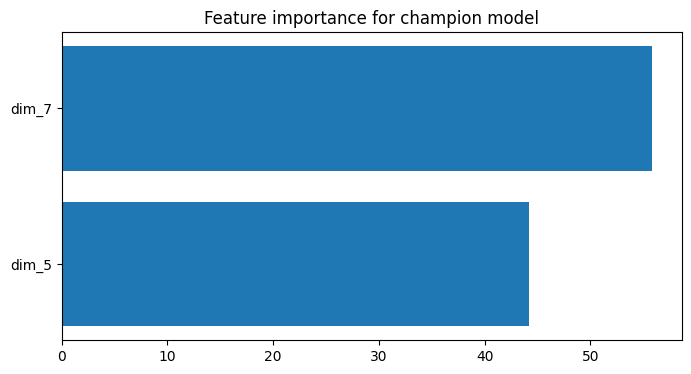

In [121]:
feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::]
sorted_features = undropped_dimensions[sorted_indices]
sorted_importance = feature_importance[sorted_indices]

plt.figure(figsize=(8, 4))
plt.barh(sorted_features, sorted_importance)
plt.title(f'Feature importance for champion model')
plt.show()
